In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import wandb
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CENTROIDS_PATH = "color_centroids.npy"

In [ ]:
class ColorizationDataset(Dataset):
    """ Custom Dataset for the CIFAR-10 Colorization task. """
    def __init__(self, base_dataset, color_centroids, use_rgb_input=False):
        self.base_dataset = base_dataset
        self.use_rgb_input = use_rgb_input
        self.centroids = torch.from_numpy(color_centroids).float()
        if use_rgb_input:
            self.to_input = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.to_input = T.Compose([
                T.Grayscale(num_output_channels=1),
                T.ToTensor(),
                T.Normalize((0.5,), (0.5,)) 
            ])
        self.to_rgb_tensor = T.ToTensor()

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.base_dataset)

    def _map_to_centroids(self, rgb_tensor_image):
        """ Maps each pixel of an RGB image to the index of the nearest color centroid."""
        pixels = rgb_tensor_image.permute(1, 2, 0).reshape(-1, 3)
        dists = torch.cdist(pixels, self.centroids)
        centroid_map = torch.argmin(dists, dim=1)
        return centroid_map.reshape(32, 32)

    def __getitem__(self, idx):
        """ Generates one sample of data. """
        pil_image, _ = self.base_dataset[idx]
        input_tensor = self.to_input(pil_image)
        rgb_tensor = self.to_rgb_tensor(pil_image)
        target_map = self._map_to_centroids(rgb_tensor)
        return input_tensor, target_map.long() 

In [ ]:
class ColorizationNet(nn.Module):
    """
    Implements the Encoder-Decoder architecture for image colorization """
    
    def __init__(self, NIC=1, NF=32, NC=24, kernel_size=3):
        super(ColorizationNet, self).__init__()
        padding = (kernel_size - 1) // 2 
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(NIC, NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(NF),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.enc_block2 = nn.Sequential(
            nn.Conv2d(NF, NF * 2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(NF * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.enc_block3 = nn.Sequential(
            nn.Conv2d(NF * 2, NF * 4, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(NF * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.dec_block1 = nn.Sequential(
            nn.ConvTranspose2d(NF * 4, NF * 2, kernel_size=2, stride=2),
            nn.BatchNorm2d(NF * 2),
            nn.ReLU(inplace=True)
        )

        self.dec_block2 = nn.Sequential(
            nn.ConvTranspose2d(NF * 2, NF, kernel_size=2, stride=2),
            nn.BatchNorm2d(NF),
            nn.ReLU(inplace=True)
        )
        
        self.dec_block3 = nn.Sequential(
            nn.ConvTranspose2d(NF, NC, kernel_size=2, stride=2),
            nn.BatchNorm2d(NC),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Conv2d(NC, NC, kernel_size=1, padding=0)

    def forward(self, x):
        """ Passes the grayscale input through the encoder-decoder network. """
        x1 = self.enc_block1(x)
        x2 = self.enc_block2(x1)
        x3 = self.enc_block3(x2)
        x4 = self.dec_block1(x3)
        x5 = self.dec_block2(x4)
        x6 = self.dec_block3(x5)
        logits = self.classifier(x6)
        return logits

In [ ]:
class ColorizationExperimentManager:
    """ Manages the full lifecycle of training, validation, logging, and visualization """
    
    def __init__(self, email_username, wandb_project="smai-a4-q2"):
        """ Initializes the manager. """
        self.email_username = email_username
        self.wandb_project = wandb_project
        self.device = DEVICE
        self.models_dir = "models"
        self.loss_curves_dir = "loss_curves"
        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.loss_curves_dir, exist_ok=True)
        if not os.path.exists(CENTROIDS_PATH):
            raise FileNotFoundError(f"'{CENTROIDS_PATH}' not found. Please download it.")
        
        self.color_centroids_np = np.load(CENTROIDS_PATH)
        self.color_centroids_np = self.color_centroids_np / 255.0
        self.color_centroids_torch = torch.from_numpy(self.color_centroids_np).float().to(self.device)
        self.sweep_config = None
        print(f"Manager initialized. Using device: {self.device}")

    def _load_data(self, batch_size, use_rgb_input=False):
        """Loads data, creates Datasets and DataLoaders."""
        base_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        base_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
        train_dataset = ColorizationDataset(base_train_set, self.color_centroids_np, use_rgb_input=use_rgb_input)
        val_dataset = ColorizationDataset(base_test_set, self.color_centroids_np, use_rgb_input=use_rgb_input)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        return train_loader, val_loader

    def _reconstruct_from_centroids(self, indices_map):
        """ Converts a [B, 32, 32] map of indices into a [B, 3, 32, 32] RGB image. """
        indices_np = indices_map.cpu().numpy()
        rgb_images_np = self.color_centroids_np[indices_np]
        rgb_images_torch = torch.from_numpy(rgb_images_np).permute(0, 3, 1, 2)
        return rgb_images_torch

    def _log_example_images(self, model, val_loader, epoch, use_rgb_input=False):
        """ Logs 10 example colourizations to wandb. """
        model.eval()
        try:
            inputs, target_maps = next(iter(val_loader))
        except StopIteration:
            return
            
        inputs, target_maps = inputs.to(self.device), target_maps.to(self.device)
        with torch.no_grad():
            pred_logits = model(inputs)
        pred_maps = torch.argmax(pred_logits, dim=1)
        pred_images = self._reconstruct_from_centroids(pred_maps)
        target_images = self._reconstruct_from_centroids(target_maps)

        if use_rgb_input:
            inputs_norm = (inputs * 0.5) + 0.5
        else:
            inputs_norm = (inputs * 0.5) + 0.5
            inputs_norm = inputs_norm.repeat(1, 3, 1, 1) 
        
        images_to_log = []
        for i in range(min(10, inputs.shape[0])):
            input_img = inputs_norm[i].cpu()
            pred = pred_images[i]
            target = target_images[i]
            combined_image = torch.cat([input_img, pred, target], dim=2) 
            input_type = "RGB" if use_rgb_input else "Gray"
            images_to_log.append(wandb.Image(
                combined_image,
                caption=f"Epoch {epoch}: {input_type} | Predicted | Ground Truth"
            ))
        wandb.log({"Example Colorizations": images_to_log})

    def _save_loss_curves(self, train_loss_history, val_loss_history, run_name):
        """ Saves the loss curves as a plot to the loss_curves folder. """
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(train_loss_history) + 1)
        plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
        plt.plot(epochs, val_loss_history, label='Validation Loss', marker='s')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss - {run_name}')
        plt.legend()
        plt.grid(True)
        plt.text(0.99, 0.01, f'@{self.email_username}', 
                transform=plt.gca().transAxes, 
                ha='right', va='bottom', 
                fontsize=8, alpha=0.5)
        loss_curve_path = os.path.join(self.loss_curves_dir, f"{run_name}_loss_curve.png")
        plt.savefig(loss_curve_path, dpi=150, bbox_inches='tight')
        plt.close()
        wandb.log({"loss_curve": wandb.Image(loss_curve_path)})
        wandb.save(loss_curve_path)

    def _train_loop(self, config, run_name, project_name=None):
        """ The main training loop for a single run. """
        project = project_name if project_name else self.wandb_project
        run = wandb.init(
            project=project,
            config=config,
            name=run_name,
            reinit=True 
        )
        
        use_rgb_input = (config['NIC'] == 3)
        train_loader, val_loader = self._load_data(config['batch_size'], use_rgb_input=use_rgb_input)
        model = ColorizationNet(
            NIC=config['NIC'],
            NF=config['NF'],
            NC=24,
            kernel_size=config['kernel_size']
        ).to(self.device)

        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        else: 
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        train_loss_history = []
        val_loss_history = []
        
        for epoch in range(config['epochs']):
            model.train()
            train_loss = 0.0
            for inputs, target_maps in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
                inputs, target_maps = inputs.to(self.device), target_maps.to(self.device)
                optimizer.zero_grad()
                pred_logits = model(inputs) 
                loss = criterion(pred_logits, target_maps)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, target_maps in tqdm(val_loader, desc=f"Epoch {epoch+1} Val"):
                    inputs, target_maps = inputs.to(self.device), target_maps.to(self.device)
                    pred_logits = model(inputs)
                    loss = criterion(pred_logits, target_maps)
                    val_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss
            })

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                wandb.summary['best_val_loss'] = best_val_loss
                model_path = os.path.join(self.models_dir, f"{run.name}_best.pth")
                torch.save(model.state_dict(), model_path)
                wandb.save(model_path)
        self._log_example_images(model, val_loader, config['epochs'], use_rgb_input=use_rgb_input)
        self._save_loss_curves(train_loss_history, val_loss_history, run.name)
        run.finish()

    def run_sweep(self, sweep_name="Q2-Colorization-Sweep", sweep_method='random', count=20, project_name=None):
        """ Initializes and runs the wandb sweep."""
        project = project_name if project_name else self.wandb_project

        self.sweep_config = {
            'method': sweep_method,
            'name': sweep_name,
            'metric': {
                'name': 'val_loss',
                'goal': 'minimize'
            },
            'parameters': {
                'epochs': {'value': 25},
                'learning_rate': {
                    'values': [1e-4, 3e-4, 1e-3, 3e-3]
                },
                'batch_size': {
                    'values': [32, 64, 128]
                },
                'NF': {
                    'values': [8, 16, 32]
                },
                'NIC': {
                    'values': [1,3]  
                },
                'kernel_size': {
                    'values': [3, 5]
                },
                'optimizer': {
                    'values': ['Adam', 'SGD']
                }
            }
        }
        
        sweep_id = wandb.sweep(self.sweep_config, project=project)
        
        def sweep_train_wrapper():
            """A wrapper to init wandb and call the main loop."""
            run = wandb.init()
            config = wandb.config
            self._train_loop(config, run.name)

        print(f"Starting sweep '{sweep_name}' with {count} runs using {sweep_method} search...")
        wandb.agent(sweep_id, function=sweep_train_wrapper, count=count)


In [5]:
manager = ColorizationExperimentManager(
    email_username="reddy.bathula",
    wandb_project="smai-a4-q2"
)

manager.run_sweep() 

Manager initialized. Using device: cuda
--- Running Analytical Solution for 32x32 ---
--- Analytical Solution (H_in = 32x32) ---
Params: NF=32, NIC=1, NC=24, k=3

Layer: Input
  - Shape Out: 	(1, 32, 32)
  - Outputs: 	1024
---
Layer: Enc1_Conv
  - Shape Out: 	(32, 32, 32)
  - Weights: 	288
  - Outputs: 	32768
  - Connections: 	294912
---
Layer: Enc1_BN/ReLU
  - Shape Out: 	(32, 32, 32)
  - Weights: 	0
  - Outputs: 	32768
  - Connections: 	0
---
Layer: Enc1_Pool
  - Shape Out: 	(32, 16, 16)
  - Weights: 	0
  - Outputs: 	8192
  - Connections: 	0
---
Layer: Enc2_Conv
  - Shape Out: 	(64, 16, 16)
  - Weights: 	18432
  - Outputs: 	16384
  - Connections: 	4718592
---
Layer: Enc2_BN/ReLU
  - Shape Out: 	(64, 16, 16)
  - Weights: 	0
  - Outputs: 	16384
  - Connections: 	0
---
Layer: Enc2_Pool
  - Shape Out: 	(64, 8, 8)
  - Weights: 	0
  - Outputs: 	4096
  - Connections: 	0
---
Layer: Enc3_Conv
  - Shape Out: 	(128, 8, 8)
  - Weights: 	73728
  - Outputs: 	8192
  - Connections: 	4718592
---
Laye

In [14]:
manager = ColorizationExperimentManager(
    email_username="reddy.bathula",
    wandb_project="smai-a4-q2"
)
manager.run_sweep(
    sweep_name="Q2-Bayesian-Optimization-Sweep",
    sweep_method='bayes',
    count=30
)

Manager initialized. Using device: cuda
Create sweep with ID: m6247snr
Sweep URL: https://wandb.ai/shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2/sweeps/m6247snr
Starting sweep 'Q2-Bayesian-Optimization-Sweep' with 30 runs using bayes search...
Create sweep with ID: m6247snr
Sweep URL: https://wandb.ai/shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2/sweeps/m6247snr
Starting sweep 'Q2-Bayesian-Optimization-Sweep' with 30 runs using bayes search...


wandb: Agent Starting Run: 93vbia88 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 157.72it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁
best_val_loss,0.72306
epoch,24
train_loss,0.77462
val_loss,0.72306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: isst62hw with config:
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam
wandb: Job received.
wandb: Agent Starting Run: isst62hw with config:
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 162.46it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.22657
epoch,24
train_loss,1.31519
val_loss,1.22657


wandb: Agent Starting Run: tn5ponyk with config:
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	optimizer: SGD
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	optimizer: SGD


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 160.07it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.22507
epoch,24
train_loss,1.28659
val_loss,1.22507


wandb: Agent Starting Run: z9ahwjn8 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: SGD
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: SGD


Epoch 25 Val: 100%|██████████| 79/79 [00:01<00:00, 41.73it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.97741
epoch,24
train_loss,1.00728
val_loss,0.9817


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ktczfad with config:
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: SGD
wandb: Job received.
wandb: Agent Starting Run: 8ktczfad with config:
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: SGD


Epoch 25 Val: 100%|██████████| 79/79 [00:01<00:00, 41.82it/s]



epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
best_val_loss,2.82203
epoch,24
train_loss,2.83032
val_loss,2.82203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xycpo629 with config:
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: SGD
wandb: Job received.
wandb: Agent Starting Run: xycpo629 with config:
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: SGD


Epoch 25 Val: 100%|██████████| 157/157 [00:01<00:00, 83.89it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
best_val_loss,2.61014
epoch,24
train_loss,2.6175
val_loss,2.61014


wandb: Agent Starting Run: 982ylh5r with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 157/157 [00:01<00:00, 81.26it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁
best_val_loss,0.73956
epoch,24
train_loss,0.75497
val_loss,0.75586


wandb: Agent Starting Run: z21cl4e7 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 158.09it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▅▄▃▃▂▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁
best_val_loss,0.72862
epoch,24
train_loss,0.75779
val_loss,0.72862


wandb: Agent Starting Run: sqxkc776 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 155.48it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁
best_val_loss,0.7192
epoch,24
train_loss,0.76273
val_loss,0.72591


wandb: Agent Starting Run: m5elqd53 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 155.60it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁
best_val_loss,0.74007
epoch,24
train_loss,0.77172
val_loss,0.75326


wandb: Agent Starting Run: s868zieg with config:
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 153.54it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▃▃▃▂▃▃▃▂▂▂▂▁▂▁▁▁▂▁▁▁▁
best_val_loss,1.35447
epoch,24
train_loss,1.34946
val_loss,1.35447


wandb: Agent Starting Run: wv3gfthh with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 159.24it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁
best_val_loss,0.73337
epoch,24
train_loss,0.77109
val_loss,0.75023


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1zovvb4q with config:
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: Job received.
wandb: Agent Starting Run: 1zovvb4q with config:
wandb: 	NF: 16
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 157.86it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▃▃▂▃▂▂▃▂▁▂▁▁▂▂▁▁▁▁
best_val_loss,0.89662
epoch,24
train_loss,0.95048
val_loss,0.92177


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k1v6j9fm with config:
wandb: 	NF: 32
wandb: Job received.
wandb: Agent Starting Run: k1v6j9fm with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 159.08it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▅▄▃▃▃▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁
best_val_loss,0.98211
epoch,24
train_loss,1.01924
val_loss,0.98469


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9eyt3brn with config:
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: Job received.
wandb: Agent Starting Run: 9eyt3brn with config:
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 159.30it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁
best_val_loss,1.06714
epoch,24
train_loss,1.14933
val_loss,1.08218


wandb: Agent Starting Run: l8fedki0 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 157.02it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
best_val_loss,0.73812
epoch,24
train_loss,0.79597
val_loss,0.73812


wandb: Agent Starting Run: 3sgbi85h with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 153.40it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
best_val_loss,0.81508
epoch,24
train_loss,0.87167
val_loss,0.81508


wandb: Agent Starting Run: iqav0ba8 with config:
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 8
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 160.52it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
best_val_loss,1.40351
epoch,24
train_loss,1.4815
val_loss,1.4059


wandb: Agent Starting Run: 1xzzcfy3 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 156.06it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
best_val_loss,0.74595
epoch,24
train_loss,0.79865
val_loss,0.7474


wandb: Agent Starting Run: 5k3wxclv with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 153.07it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
best_val_loss,0.74459
epoch,24
train_loss,0.77665
val_loss,0.74893


wandb: Agent Starting Run: 93opur75 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 142.02it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▃▂▂▂▃▂▂▂▁▂▁▁▁▁▁
best_val_loss,0.73006
epoch,24
train_loss,0.77384
val_loss,0.73006


wandb: Agent Starting Run: iejqah30 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 142.60it/s]



epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.8118
epoch,24
train_loss,0.8693
val_loss,0.8118


wandb: Agent Starting Run: ibdwqv8e with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:01<00:00, 157.07it/s]



epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂
best_val_loss,0.73284
epoch,24
train_loss,0.76664
val_loss,0.76567


wandb: Agent Starting Run: hvyzdwdr with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 156.06it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
best_val_loss,0.75323
epoch,24
train_loss,0.80706
val_loss,0.75323


wandb: Agent Starting Run: kkp09o06 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 156.39it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁
best_val_loss,0.73983
epoch,24
train_loss,0.76664
val_loss,0.74173


wandb: Agent Starting Run: 2r2oy66g with config:
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 151.47it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.42806
epoch,24
train_loss,1.45269
val_loss,1.42806


wandb: Agent Starting Run: nhuoecay with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 156.30it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂
best_val_loss,0.74136
epoch,24
train_loss,0.80478
val_loss,0.77917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Job received.
wandb: Agent Starting Run: du3u9h01 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: Agent Starting Run: du3u9h01 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 154.64it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
best_val_loss,0.75103
epoch,24
train_loss,0.7986
val_loss,0.75531


wandb: Agent Starting Run: zxw4s5y1 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 153.58it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
best_val_loss,0.74218
epoch,24
train_loss,0.79365
val_loss,0.75687


wandb: Agent Starting Run: rbvl4k46 with config:
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam
wandb: 	NF: 32
wandb: 	NIC: 3
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: Adam


Epoch 25 Val: 100%|██████████| 313/313 [00:02<00:00, 150.62it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
best_val_loss,0.76269
epoch,24
train_loss,0.80226
val_loss,0.76451


# Best Model

In [ ]:
EMAIL_USERNAME = "reddy.bathula"
api = wandb.Api()

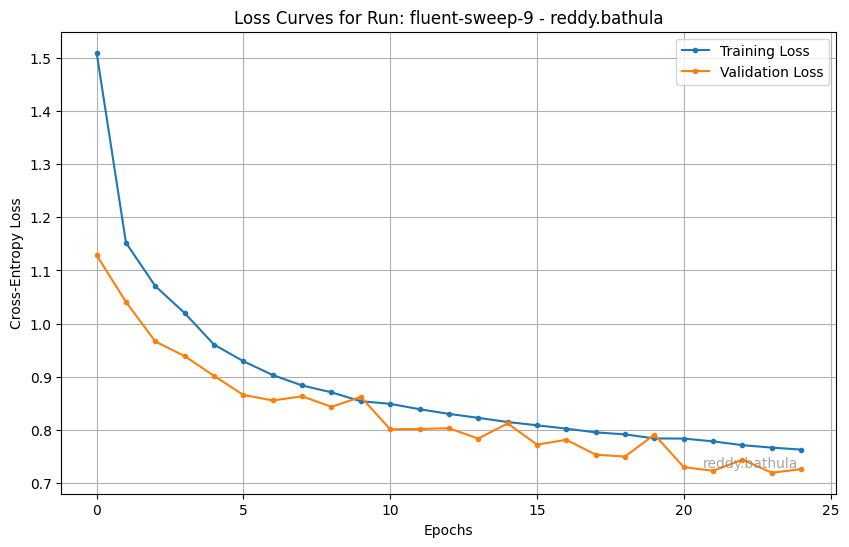

Plotting 10 images...


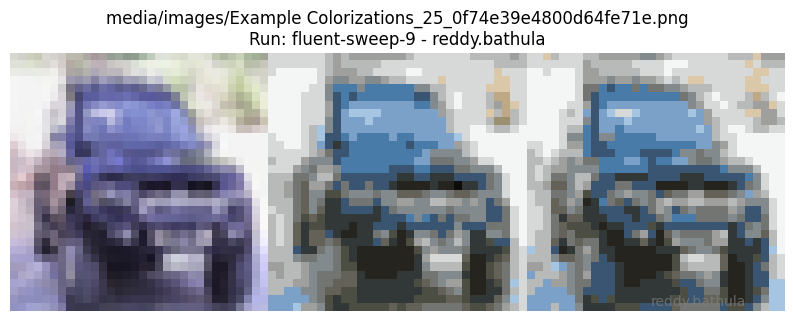

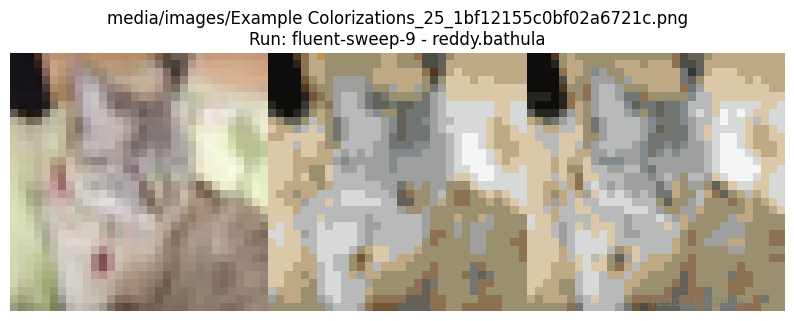

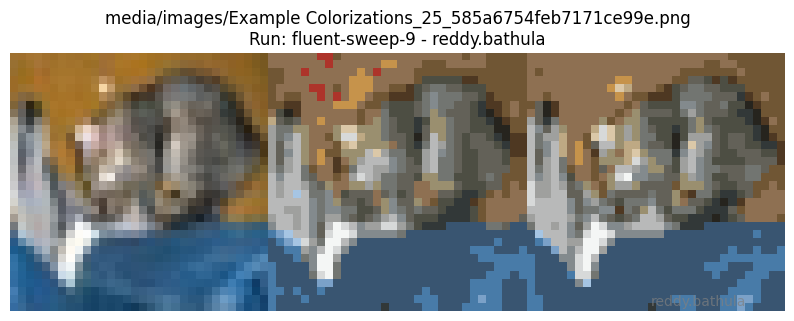

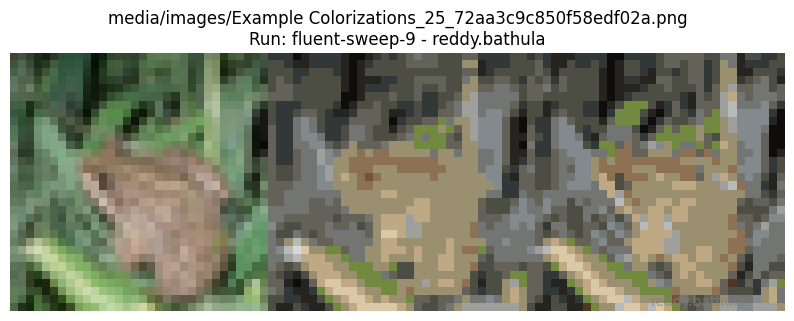

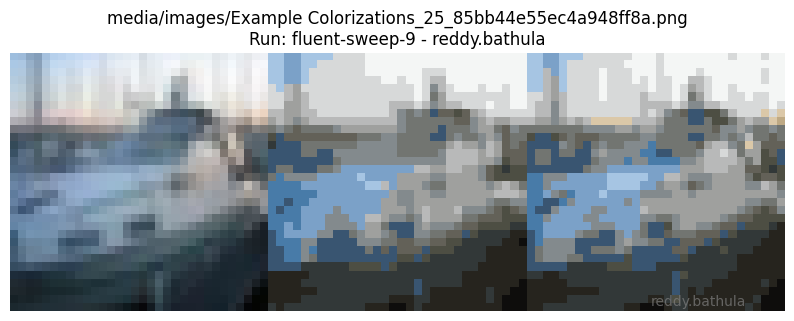

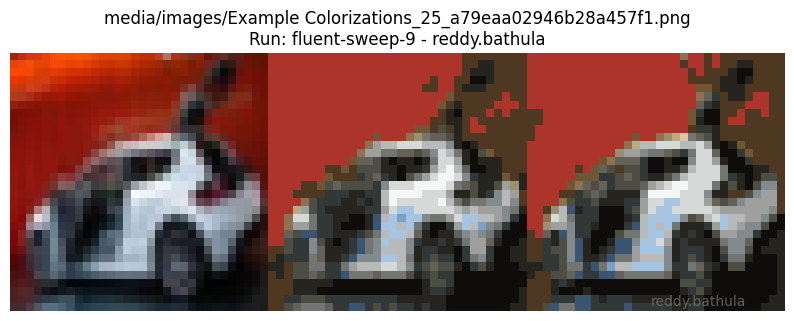

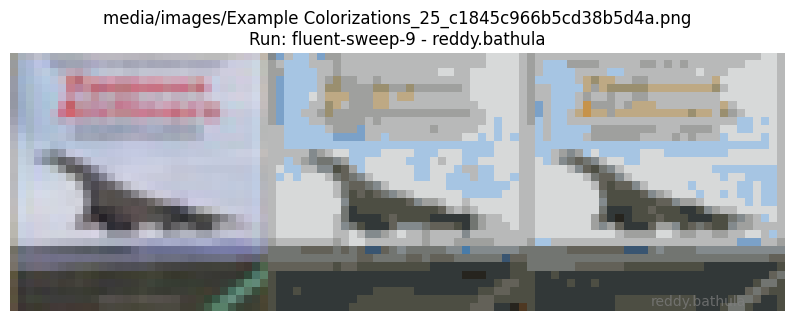

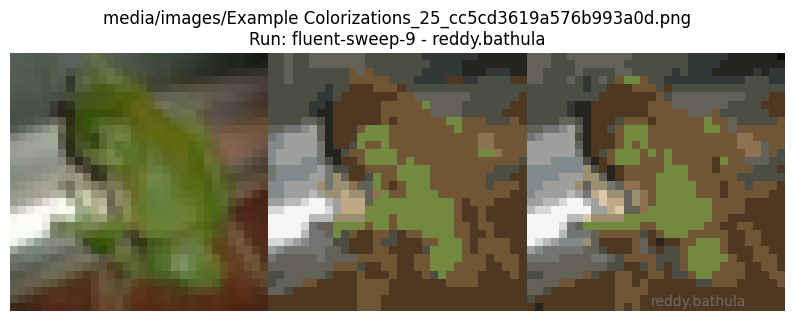

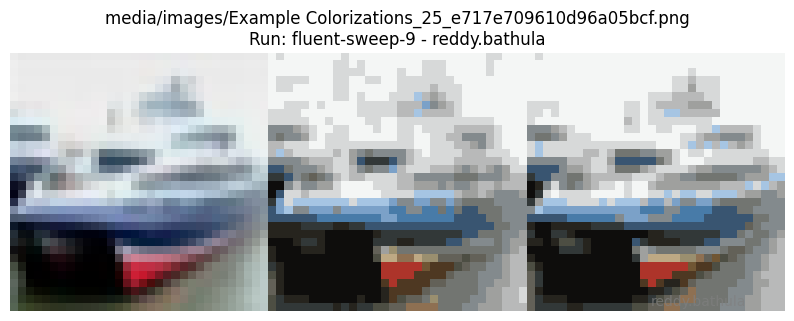

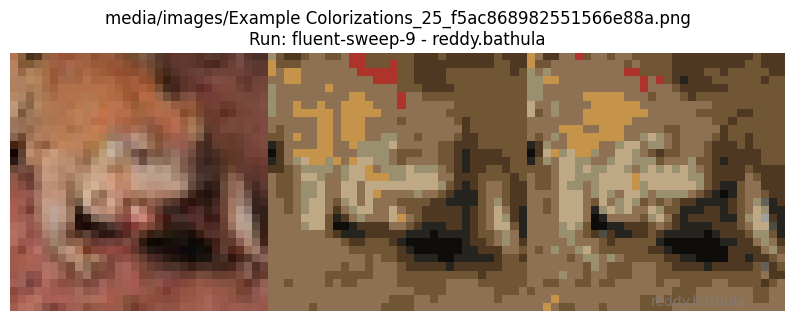

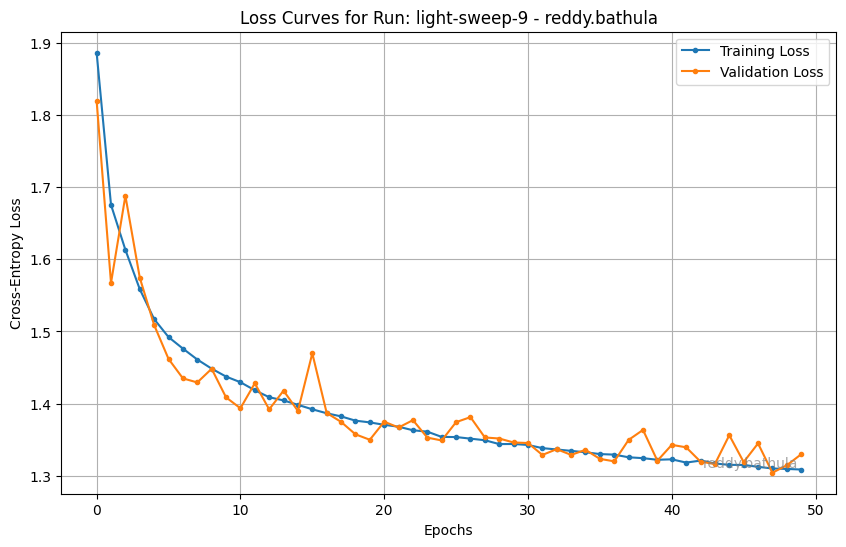

Plotting 10 images...


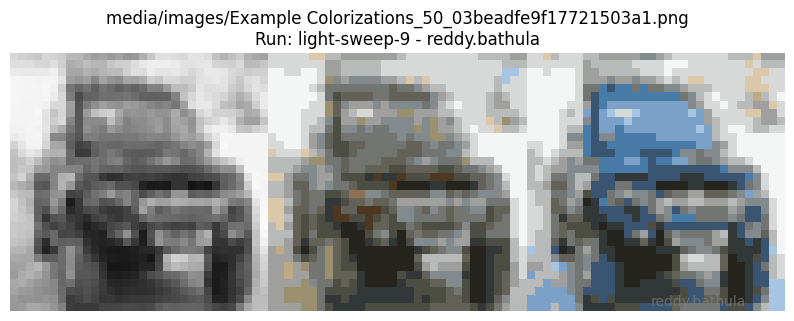

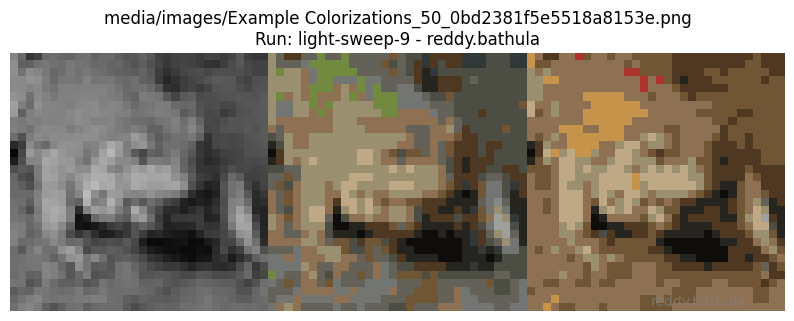

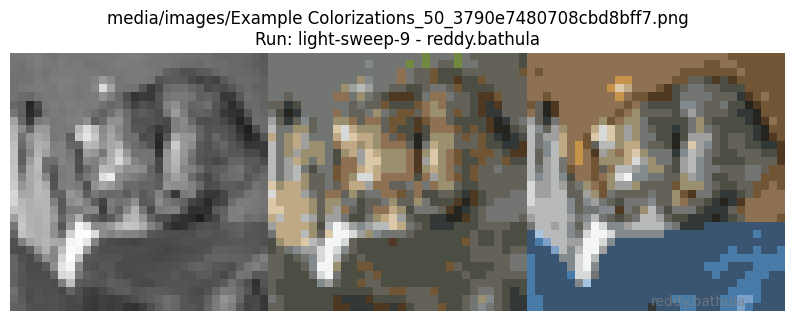

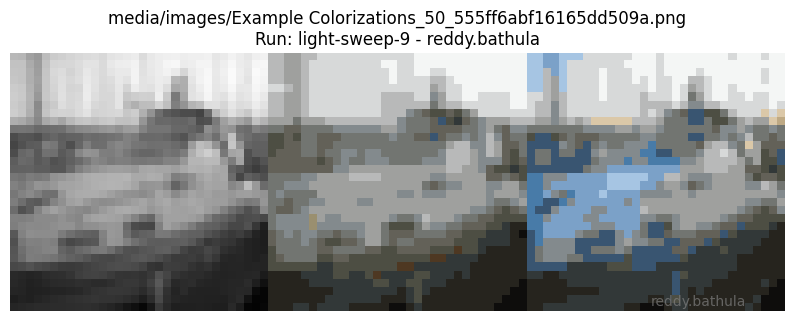

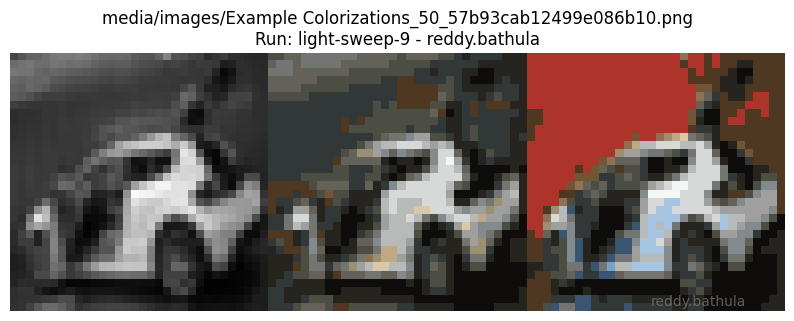

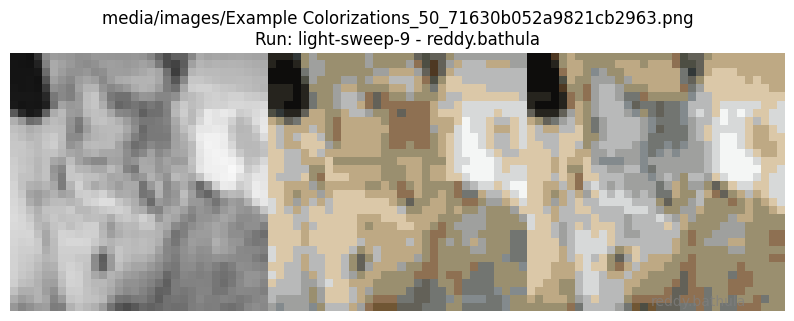

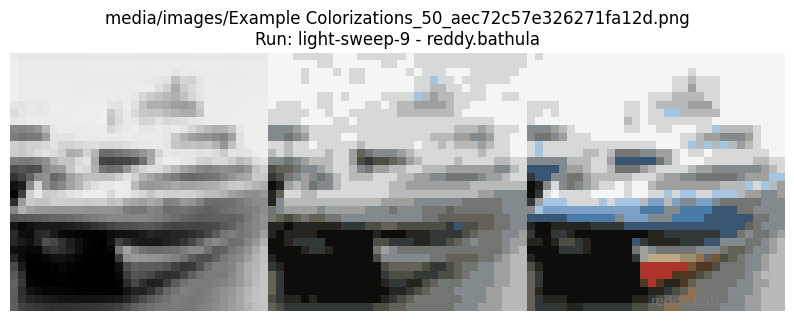

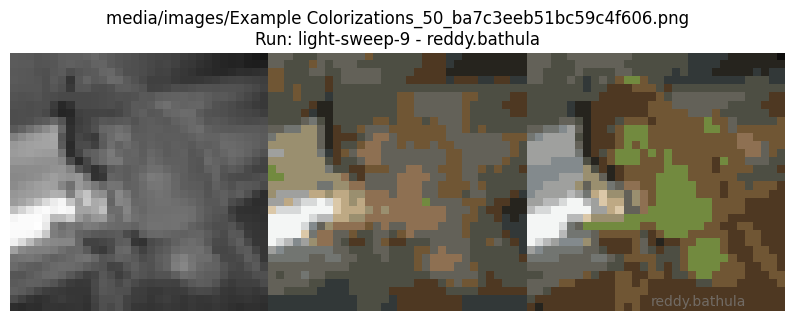

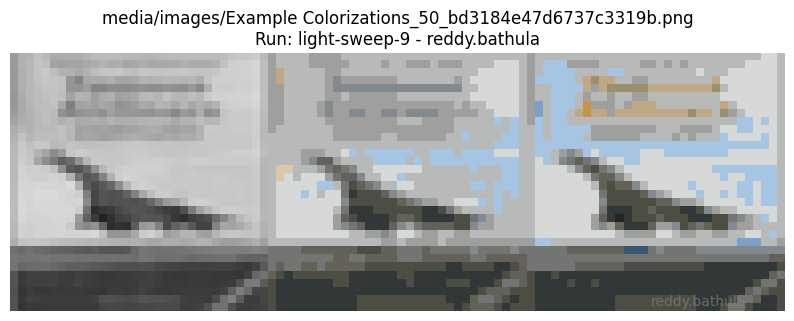

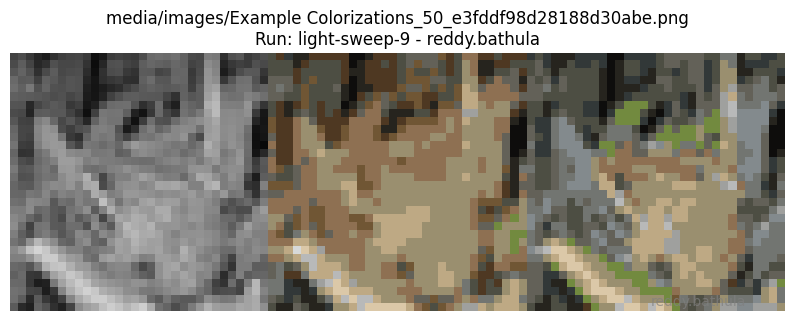

In [ ]:
color_config = { # fluent-sweep-9
    'epochs': 25, 
    'learning_rate': 0.001,
    'batch_size': 32,
    'NF': 32,
    'kernel_size': 5,
    'optimizer': 'Adam',
    'NIC': 3, 
}

grayscale_config = { # light-sweep-9
    'epochs': 50, 
    'learning_rate': 0.003,
    'batch_size': 32,
    'NF': 32,
    'kernel_size': 5,
    'optimizer': 'Adam',
    'NIC': 1, 
}

best_models = ["shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2/sqxkc776",
               "shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2/neoccavp"]


for run_path in best_models:
    run = api.run(run_path)
    history = run.history(keys=["epoch", "train_loss", "val_loss"])
    plt.figure(figsize=(10, 6))

    plt.plot(
        history['epoch'], 
        history['train_loss'], 
        label='Training Loss', 
        marker='.'
    )
    plt.plot(
        history['epoch'], 
        history['val_loss'], 
        label='Validation Loss', 
        marker='.'
    )
    plt.text(
        0.95, 0.05, EMAIL_USERNAME, ha='right', va='bottom',
        transform=plt.gca().transAxes,
        fontsize=10, color='gray', alpha=0.7
    )

    plt.title(f'Loss Curves for Run: {run.name} - {EMAIL_USERNAME}')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    image_files = []
    downloaded_paths = []
    last_epoch = run.summary.get('epoch', 25) 
        
    for file in run.files():
        if file.name.startswith(f"media/images/Example Colorizations"):
            image_files.append(file.name)
    
    if not image_files:
        print("No example images found for the last epoch.")
        continue

    for f_name in image_files:
        try:
            file_obj = run.file(f_name)
            file_obj.download(root=".", replace=True)
            downloaded_paths.append(f_name)
        except Exception as e:
            print(f"Warning: Could not download {f_name}. Error: {e}")

    print(f"Plotting {len(downloaded_paths)} images...")
    for local_file_path in downloaded_paths:
        try:
            img = mpimg.imread(local_file_path)
            plt.figure(figsize=(10, 8)) 
            plt.imshow(img)
            plt.title(f"{local_file_path}\nRun: {run.name} - {EMAIL_USERNAME}")
            plt.axis('off')
            plt.text(
                0.95, 0.01, EMAIL_USERNAME, ha='right', va='bottom',
                transform=plt.gca().transAxes,
                fontsize=10, color='gray', alpha=0.7
            )
            plt.show()
            os.remove(local_file_path)

        except Exception as e:
            print(f"Error displaying {local_file_path}: {e}")

## Analytical Questions

Symbolic calculations for the model architecture.
Assumptions
 - Input ($H_{in}$): $32 \times 32$ for the first part, $64 \times 64$ for the second.
 - Encoder Conv2d: We assume a kernel_size $k_{conv}$, stride=1, and padding="same" ($p_{conv} = (k_{conv}-1)/2$). This means the spatial dimensions ($H \times W$) are unchanged by the convolution.
 - Encoder MaxPool2d: We assume a kernel_size=2 and stride=2. This halves the spatial dimensions.
 - Decoder ConvTranspose2d: The diagram specifies kernel_size=2 ($k_{deconv}=2$) and stride=2. This doubles the spatial dimensions.
 - Classifier Conv2d: The diagram specifies a $1 \times 1$ convolution, so kernel_size=1 ($k_{class}=1$) and padding=0.
 - Ignored Parameters: All biases and BatchNorm parameters are ignored.

Formulas Used:
- Weights (Conv/Deconv): $(\text{kernel\_h} \times \text{kernel\_w} \times C_{in}) \times C_{out}$
- Outputs (Activations): $H_{out} \times W_{out} \times C_{out}$
- Connections (Conv/Deconv): $\text{Weights} \times H_{out} \times W_{out}$

| Layer | Input Shape (C, H, W) | Output Shape (C, H, W) | Weights | Outputs | Connections |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Input | (NIC, 32, 32) | (NIC, 32, 32) | 0 | $1024 \times \text{NIC}$ | 0 |
| Enc1_Conv | (NIC, 32, 32) | (NF, 32, 32) | $k_{conv}^2 \times \text{NIC} \times \text{NF}$ | $1024 \times \text{NF}$ | $1024 \times k_{conv}^2 \times \text{NIC} \times \text{NF}$ |
| Enc1_Pool | (NF, 32, 32) | (NF, 16, 16) | 0 | $256 \times \text{NF}$ | 0 |
| Enc2_Conv | (NF, 16, 16) | (2NF, 16, 16) | $k_{conv}^2 \times \text{NF} \times 2\text{NF}$ | $256 \times 2\text{NF}$ | $256 \times k_{conv}^2 \times 2\text{NF}^2$ |
| Enc2_Pool | (2NF, 16, 16) | (2NF, 8, 8) | 0 | $64 \times 2\text{NF}$ | 0 |
| Enc3_Conv | (2NF, 8, 8) | (4NF, 8, 8) | $k_{conv}^2 \times 2\text{NF} \times 4\text{NF}$ | $64 \times 4\text{NF}$ | $64 \times k_{conv}^2 \times 8\text{NF}^2$ |
| Enc3_Pool | (4NF, 8, 8) | (4NF, 4, 4) | 0 | $16 \times 4\text{NF}$ | 0 |
| Dec1_Deconv | (4NF, 4, 4) | (2NF, 8, 8) | $k_{deconv}^2 \times 4\text{NF} \times 2\text{NF}$ | $64 \times 2\text{NF}$ | $64 \times k_{deconv}^2 \times 8\text{NF}^2$ |
| Dec2_Deconv | (2NF, 8, 8) | (NF, 16, 16) | $k_{deconv}^2 \times 2\text{NF} \times \text{NF}$ | $256 \times \text{NF}$ | $256 \times k_{deconv}^2 \times 2\text{NF}^2$ |
| Dec3_Deconv | (NF, 16, 16) | (NC, 32, 32) | $k_{deconv}^2 \times \text{NF} \times \text{NC}$ | $1024 \times \text{NC}$ | $1024 \times k_{deconv}^2 \times \text{NF} \times \text{NC}$ |
| Class_Conv | (NC, 32, 32) | (NC, 32, 32) | $k_{class}^2 \times \text{NC} \times \text{NC}$ | $1024 \times \text{NC}$ | $1024 \times k_{class}^2 \times \text{NC}^2$ |

Final Totals (Input $32 \times 32$) 
- Total Number of Weights:
    - = (Sum of Weights column)
    - = $(k_{conv}^2 \times \text{NIC} \times \text{NF}) + (k_{conv}^2 \times 2\text{NF}^2) + (k_{conv}^2 \times 8\text{NF}^2) + (4 \times 8\text{NF}^2) + (4 \times 2\text{NF}^2) + (4 \times \text{NF} \times \text{NC}) + (1 \times \text{NC}^2)$
    - = $k_{conv}^2(\text{NIC} \times \text{NF} + 10\text{NF}^2) + 40\text{NF}^2 + 4\text{NF} \times \text{NC} + \text{NC}^2$. 
- Total Number of Outputs (Activations):
    - = (Sum of Outputs column)
    - = $(1024 \times \text{NIC}) + (1024 \times \text{NF}) + (256 \times \text{NF}) + (512 \times \text{NF}) + (128 \times \text{NF}) + (256 \times \text{NF}) + (64 \times \text{NF}) + (128 \times \text{NF}) + (256 \times \text{NF}) + (1024 \times \text{NC}) + (1024 \times \text{NC})$
    - = $1024 \times \text{NIC} + 2624 \times \text{NF} + 2048 \times \text{NC}$
- Total Number of Connections:
    - = (Sum of Connections column)
    - = $(1024 \times k_{conv}^2 \times \text{NIC} \times \text{NF}) + (256 \times k_{conv}^2 \times 2\text{NF}^2) + (64 \times k_{conv}^2 \times 8\text{NF}^2) + (64 \times 4 \times 8\text{NF}^2) + (256 \times 4 \times 2\text{NF}^2) + (1024 \times 4 \times \text{NF} \times \text{NC}) + (1024 \times 1 \times \text{NC}^2)$
    - = $1024 \times k_{conv}^2 \times \text{NIC} \times \text{NF} + 512 \times k_{conv}^2 \times \text{NF}^2 + 512 \times k_{conv}^2 \times \text{NF}^2 + 2048\text{NF}^2 + 2048\text{NF}^2 + 4096\text{NF} \times \text{NC} + 1024\text{NC}^2$
    - = $1024 \times [ k_{conv}^2(\text{NIC} \times \text{NF} + \text{NF}^2) + 4\text{NF}^2 + 4\text{NF} \times \text{NC} + \text{NC}^2 ]$

Input Spatial Size $64 \times 64$
- The spatial dimensions are now doubled. $H_{in} \times W_{in} = 4096$. We update the $H \times W$ multiplier for each layer's "Outputs" and "Connections" calculation.
    - Input / Enc1_Conv: $H \times W = 4096$
    - Enc1_Pool / Enc2_Conv: $H \times W = 1024$
    - Enc2_Pool / Enc3_Conv: $H \times W = 256$
    - Enc3_Pool / Dec1_Deconv: $H \times W = 64$
    - Dec1_Deconv_Out / Dec2_Deconv: $H \times W = 256$
    - Dec2_Deconv_Out / Dec3_Deconv: $H \times W = 1024$
    - Dec3_Deconv_Out / Class_Conv: $H \times W = 4096$

- Final Totals (Input $64 \times 64$)
    - Total Number of Weights:
        - Unchanged. The number of weights in a convolutional kernel is independent of the spatial size of the input image.
        - = $k_{conv}^2(\text{NIC} \times \text{NF} + 10\text{NF}^2) + 40\text{NF}^2 + 4\text{NF} \times \text{NC} + \text{NC}^2$
    - Total Number of Outputs (Activations):
        - = (Sum of $H \times W \times C$ for each layer, using the new $H \times W$ values)
        - = $(4096 \times \text{NIC}) + (4096 \times \text{NF}) + (1024 \times \text{NF}) + (1024 \times 2\text{NF}) + (256 \times 2\text{NF}) + (256 \times 4\text{NF}) + (64 \times 4\text{NF}) + (256 \times 2\text{NF}) + (1024 \times \text{NF}) + (4096 \times \text{NC}) + (4096 \times \text{NC})$
        - = $4096 \times \text{NIC} + (4096+1024+2048+512+1024+256+512+1024) \times \text{NF} + (4096+4096) \times \text{NC}$
        - = $4096 \times \text{NIC} + 10496 \times \text{NF} + 8192 \times \text{NC}$
    - Total Number of Connections:
        - = (Sum of $\text{Weights} \times H_{out} \times W_{out}$ for each layer)
        - = $(4096 \times k_{conv}^2 \times \text{NIC} \times \text{NF}) + (1024 \times k_{conv}^2 \times 2\text{NF}^2) + (256 \times k_{conv}^2 \times 8\text{NF}^2) + (256 \times 4 \times 8\text{NF}^2) + (1024 \times 4 \times 2\text{NF}^2) + (4096 \times 4 \times \text{NF} \times \text{NC}) + (4096 \times 1 \times \text{NC}^2)$
        - = $4096 \times k_{conv}^2 \times \text{NIC} \times \text{NF} + 2048 \times k_{conv}^2 \times \text{NF}^2 + 2048 \times k_{conv}^2 \times \text{NF}^2 + 8192\text{NF}^2 + 8192\text{NF}^2 + 16384\text{NF} \times \text{NC} + 4096\text{NC}^2$
        - = $4096 \times [ k_{conv}^2(\text{NIC} \times \text{NF} + \text{NF}^2) + 4\text{NF}^2 + 4\text{NF} \times \text{NC} + \text{NC}^2 ]$

# Sweep Wandb link
- Workspace: https://wandb.ai/shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2
- Sweeps: https://wandb.ai/shailendrasekhar-bathula-iiit-hyderabad/smai-a4-q2/sweeps